https://zhajiman.github.io/post/pytorch_time_series_tutorial/


In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f

In [241]:
df = pd.read_csv("electricity.csv", encoding="utf-8")
df.head(5)

,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,OT
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [242]:
df.index = pd.to_datetime(df.pop("date"))
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,OT
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [243]:
P = len(df)
interest_keys = ["OT", "1"]
C = len(interest_keys)
interest_data = df[interest_keys][:P]
interest_data.head(5)

,OT,1
date,,
2016-07-01 02:00:00,2162.0,69.0
2016-07-01 03:00:00,2835.0,92.0
2016-07-01 04:00:00,2764.0,96.0
2016-07-01 05:00:00,2735.0,92.0
2016-07-01 06:00:00,2721.0,91.0


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

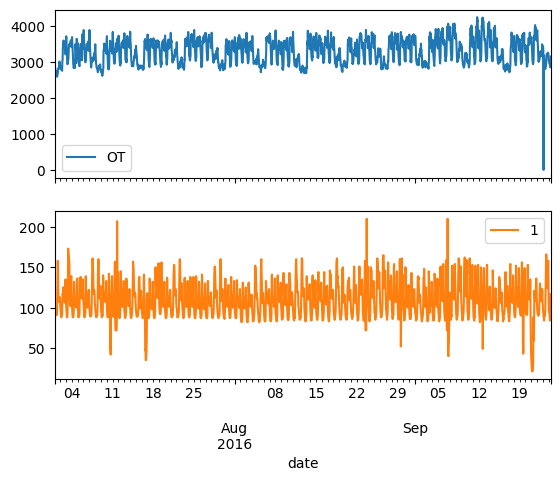

In [244]:
interest_data.plot(subplots=True)


In [245]:
interest_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
OT,2048.0,3282.821777,332.791447,0.0,2991.75,3309.5,3554.0,4233.0
1,2048.0,109.194824,22.006186,21.0,91.00,109.0,122.0,210.0


$$
H_{out}=\lfloor\frac{H_{in}+2\times padding[0]- kernel\_size[0]}{stride[0]}+1\rfloor\\W_{out}=\lfloor\frac{W_{in}+2\times padding[1]-kernel\_size[1]}{stride[1]}+1\rfloor
$$


In [246]:
t = torch.tensor(interest_data.index.astype(int) / 10**9 / 3600)
t.shape

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10536\2545397256.py:1: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  t = torch.tensor(interest_data.index.astype(int) / 10**9 / 3600)


torch.Size([2048])

In [247]:
X = torch.tensor([interest_data[k] for k in interest_keys])
X

tensor([[2162., 2835., 2764.,  ..., 2843., 2926., 3142.],
        [  69.,   92.,   96.,  ...,   87.,   96.,  117.]], dtype=torch.float64)

In [248]:
X = f.normalize(X, dim=1)

In [249]:
stride = 1
kernel_size = 25
# padding = nn.ReplicationPad1d(padding=(kernel_size - stride) // 2)
padding = nn.ZeroPad1d(padding=(kernel_size - stride) // 2)
avg_pool = nn.AvgPool1d(
    kernel_size=kernel_size,
    stride=stride,
)

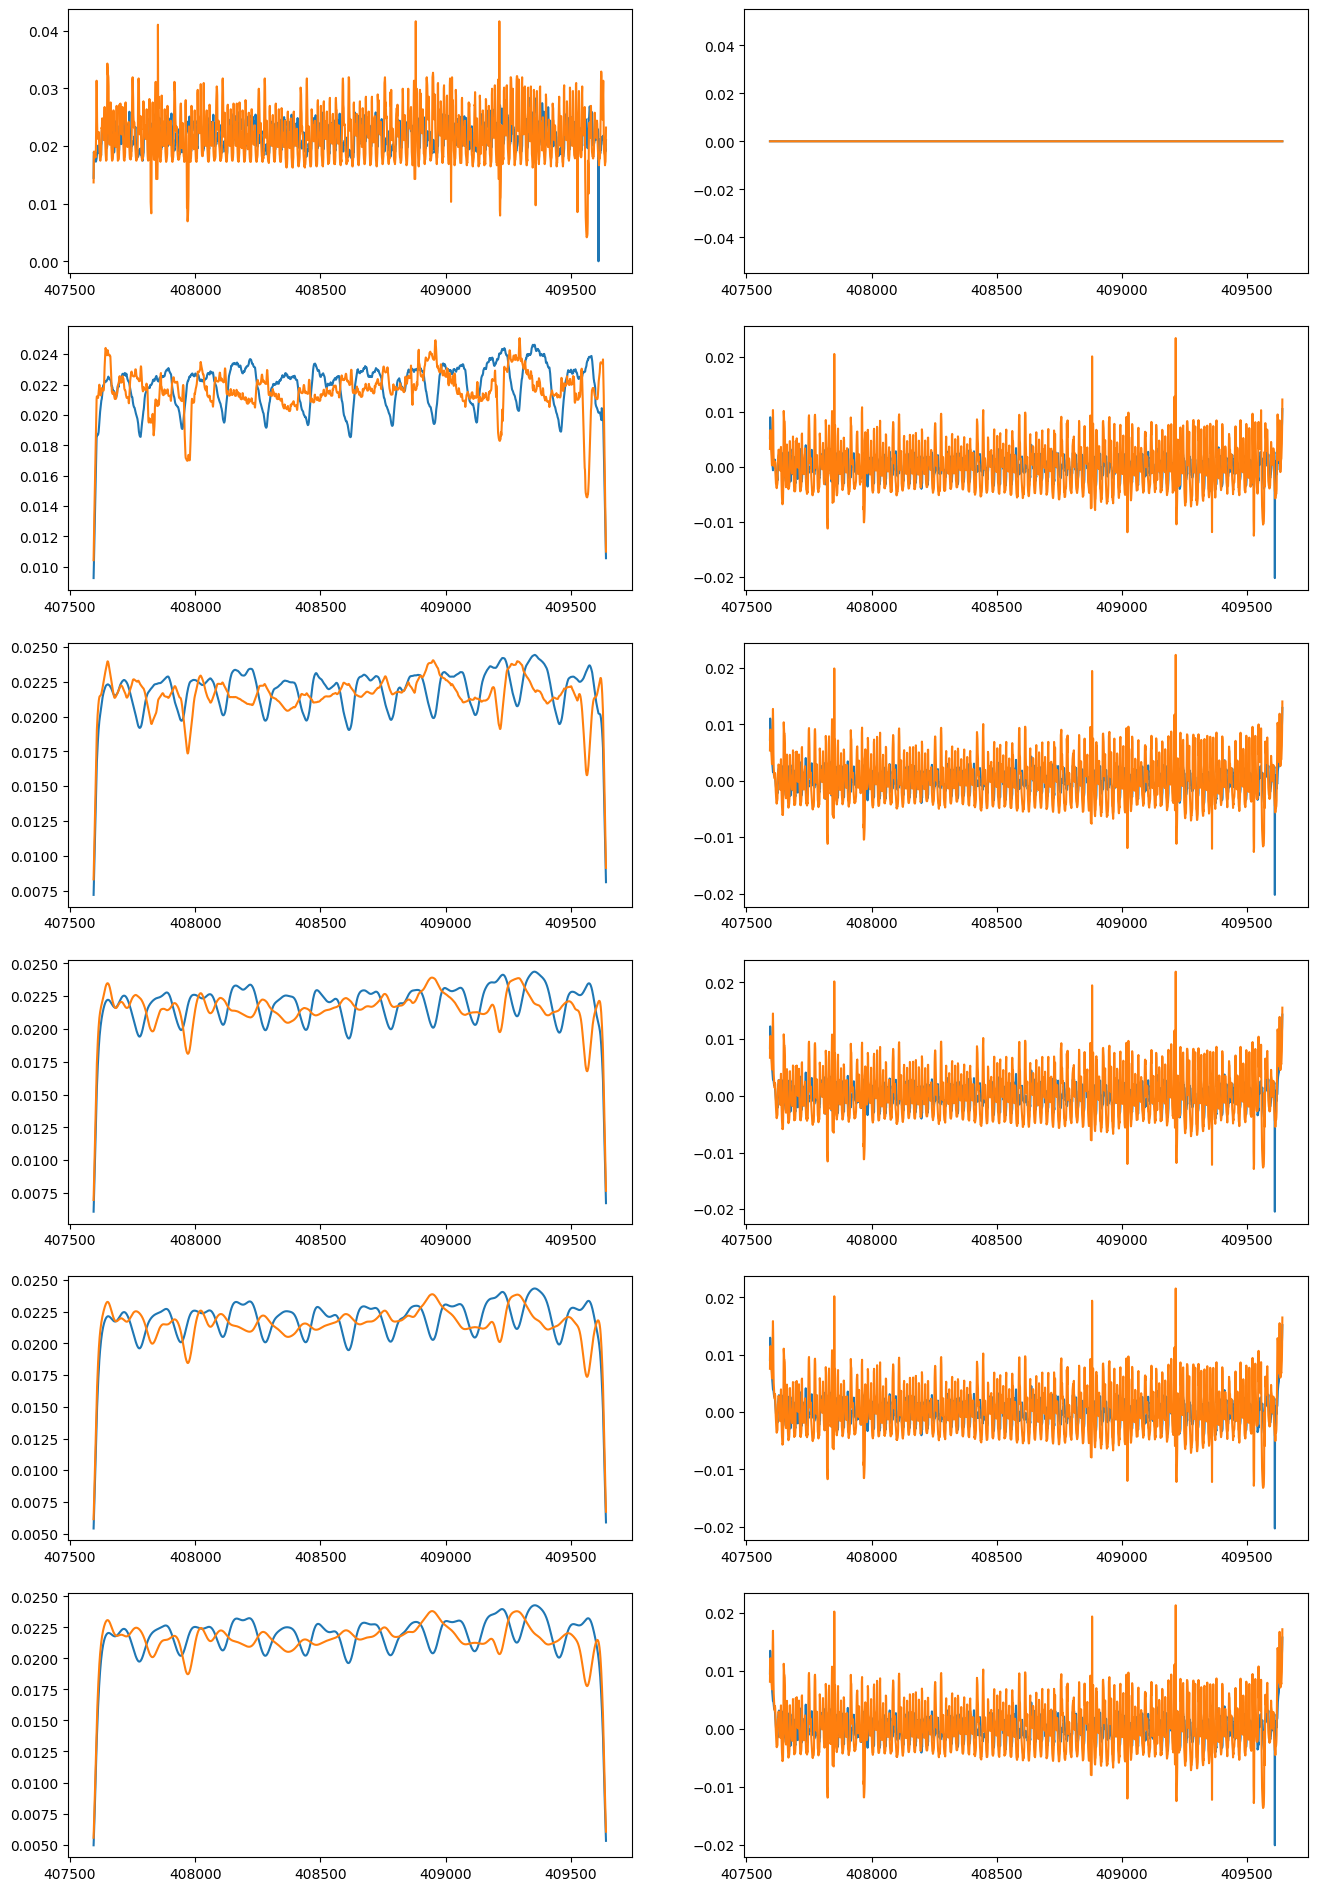

In [250]:
from functools import lru_cache


@lru_cache
def avg_move_nth(n):
    if n < 0:
        raise Exception("wrong n")
    if n == 0:
        return X
    if n == 1:
        return avg_pool(padding(X))
    else:
        return avg_pool(padding(avg_move_nth(n - 1)))


total_plot_rows = 6

plt.figure(figsize=(16, total_plot_rows * 4))


def plot_avg_move_nth(n):
    plt.subplot(total_plot_rows, 2, 2 * n + 1)
    X_trend = avg_move_nth(n)
    plt.plot(t.repeat(C, 1).transpose(0, 1), X_trend.transpose(0, 1))
    plt.subplot(total_plot_rows, 2, 2 * n + 2)
    X_season = X - X_trend
    plt.plot(t.repeat(C, 1).transpose(0, 1), X_season.transpose(0, 1))


for n in range(total_plot_rows):
    plot_avg_move_nth(n)

| 总结

一次的趋势化足够明显

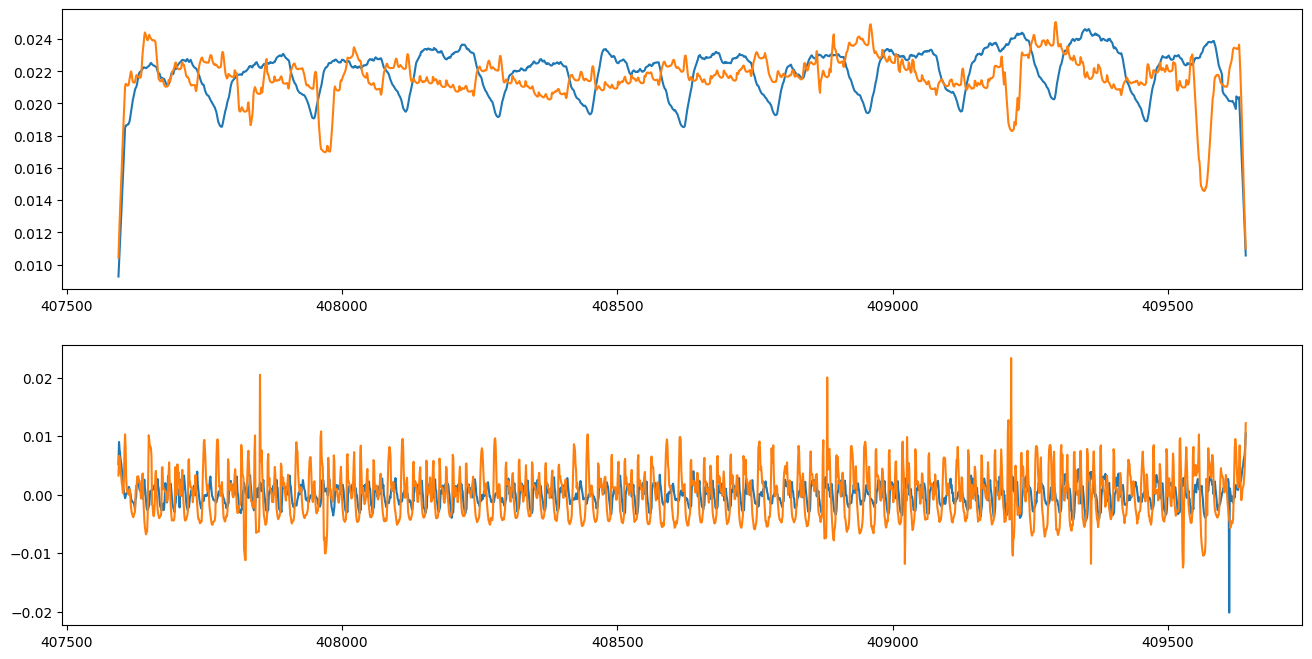

In [251]:
plt.figure(figsize=(16, C * 4))
plt.subplot(2, 1, 1)
Xt = avg_pool(padding(X))
plt.plot(t.repeat(C, 1).transpose(0, 1), Xt.transpose(0, 1))
plt.subplot(2, 1, 2)
Xs = X - Xt
plt.plot(t.repeat(C, 1).transpose(0, 1), Xs.transpose(0, 1))

In [252]:
sample_interval = t[1] - t[0]
sample_interval

tensor(1., dtype=torch.float64)

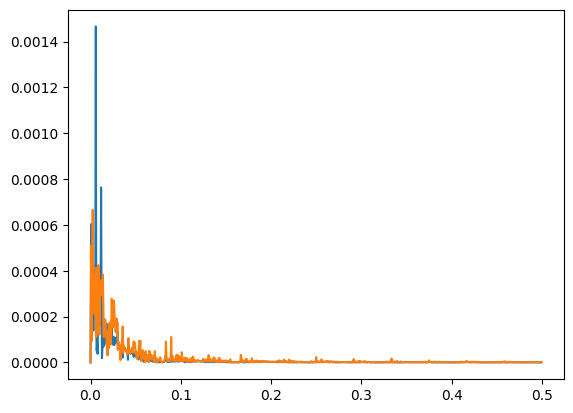

In [253]:
amps = torch.abs(torch.fft.fft(Xt)[:, : P // 2]) / P * 2
amps[:, 0] = 0 # 去除常数（基线）
freqs = 1 / sample_interval * torch.arange(P)[: P // 2] / P

plt.plot(freqs.repeat(C, 1).transpose(0, 1), amps.transpose(0, 1))

不明显，对数化

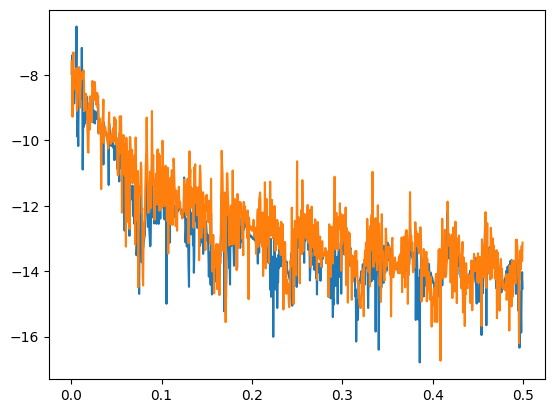

In [254]:
plt.plot(freqs.repeat(C, 1).transpose(0, 1), torch.log(amps).transpose(0, 1))

In [255]:
topk = torch.topk(amps, dim=1, k=1)

topk

torch.return_types.topk(
values=tensor([[0.0015],
        [0.0007]], dtype=torch.float64),
indices=tensor([[12],
        [ 5]]))

In [256]:
main_freq = freqs[topk.indices].squeeze()

main_freq

tensor([0.0059, 0.0024], dtype=torch.float64)

In [257]:
main_interval = 1 / main_freq

main_interval

tensor([170.6667, 409.6000], dtype=torch.float64)

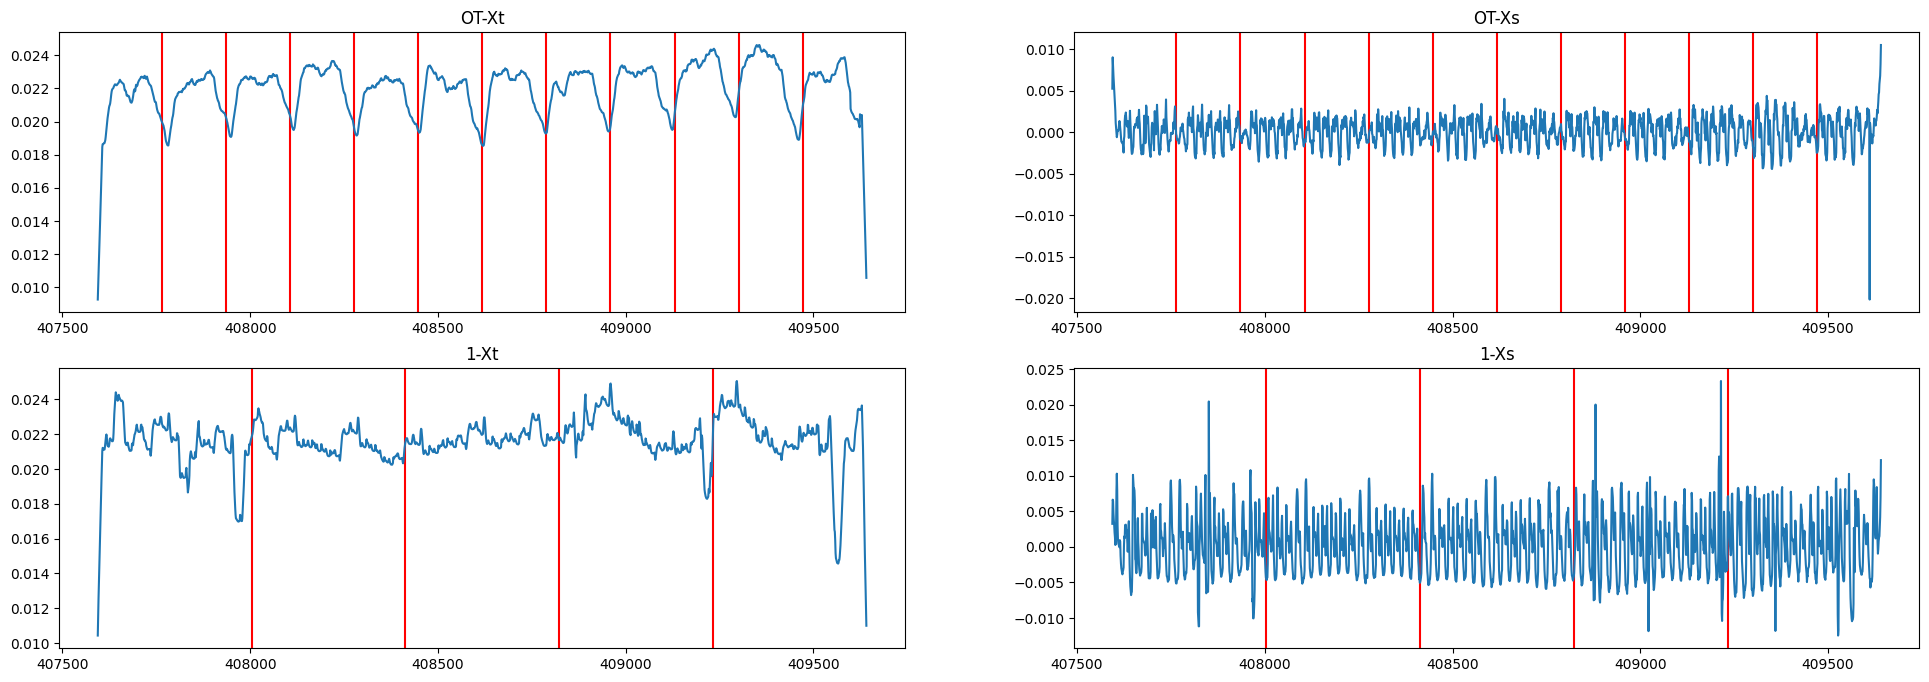

In [259]:
# TODO 将每个周期标在每个变量的X图上

plt.figure(figsize=(24, C * 4))

for i in range(C):
    inteval = main_interval[i]
    periods = torch.arange(t.min() + inteval, t.max(), inteval)
    # Xt for var[i]
    Xti = Xt[i]
    plt.subplot(C, 2, 2 * i + 1)
    plt.title(f"{interest_keys[i]}-Xt")
    for p in periods:
        plt.axvline(x=p, color="r")
    plt.plot(t, Xti)
    # Xs for var[i]
    Xsi = Xs[i]
    plt.subplot(C, 2, 2 * i + 2)
    for p in periods:
        plt.axvline(x=p, color="r")
    plt.title(f"{interest_keys[i]}-Xs")
    plt.plot(t, Xsi)